In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.linalg import toeplitz
import cvxpy as cp
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
plt.rc("figure", figsize=(24, 8))

L'objectif de ce notebook est de présenter quelques méthodes d'estimation non-paramétrique de tendance, lorsque celle-ci est non-régulière (discontinue), par optimisation (ici convexe).

Sample a continuous signal and add Gaussian white noise

In [3]:
np.random.seed(403)
n = 2 * 10**3
t = np.arange(n)
x_true = signal.square(t * 2 * np.pi * 3/n) 
# x_true *= np.sin(t * 2 * np.pi * (10/n))
# x_true += t/10**3
noise = np.random.normal(size=n, scale=0.5, loc=0.0)
x_cor = x_true + noise

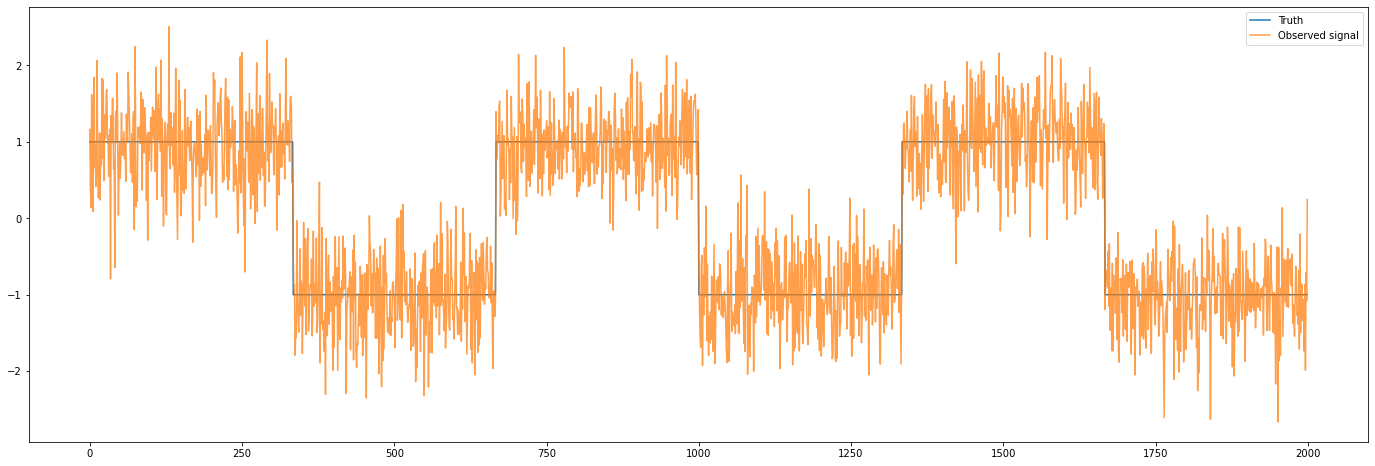

In [4]:
plt.plot(t, x_true, label='Truth')
plt.plot(t, x_cor, alpha=0.75, label='Observed signal')

plt.legend()

Nous cherchons à retrouver le signal original (bleu) à partie du signal bruité. Il s'agit donc d'estimer la tendance du signal bruité. En traitement du signal, on parle de "débruitage" (denoising).

Notons la série temporelle (signal) observée $(x_t)_{t \leq T}$ et le bruit (non observé) $(\epsilon_t)_t$ supposé fortement stationnaire. Nous proposons d'estimer la version débruité de $(x_t)_t$ par $(\hat{u}_t)_t$ selon:
$$
(\hat{u}_t)_t = \arg \min_{(u_t)_{t \leq T}} \frac{1}{2} \sum_{i=1}^T (u_i - x_i)^2 + \alpha R\big( (u_t)_t \big)
$$
où $\alpha > 0$ et $R(\cdot)$ est une fonction strictement convexe, appelée régularisation, et encode un priori que l'on a sur la solution à ce problème, i.e sur notre tendance.

Exemples:
- $R\big( (u_t)_t \big) = ||(u_t)_t||_{\ell_2}^2 = \sum_{i=1}^T u_i^2$, carré de la norme $\ell_2$),
- $R\big( (u_t)_t \big) = ||\nabla_2 (u_t)_t||_{\ell_2}^2 = \sum_{i=2}^{T-1} (u_{i-1} -2 u_{i}  + u_{i+1})^2$,  dîte régularisation de Tikhonov,
- $R\big( (u_t)_t \big) = ||\nabla_1 (u_t)_t||_{\ell_1} = \sum_{i=2}^T |u_{i+1} -u_{i}|$,  dîte variation-totale en une dimension ("1D Total-variation"),
- $R\big( (u_t)_t \big) = ||\nabla_1 (u_t)_t||_{\ell_2}^2$
- $R\big( (u_t)_t \big) = ||\nabla_2 (u_t)_t||_{\ell_2}^2$
- $R\big( (u_t)_t \big) = ||\nabla_2 (u_t)_t||_{\ell_2}^2 + ||(u_t)_t||_{\ell_2}^2$
- ...

L'idée est d'appliquer une fonction convexe sur un opérateur linéaire (ici de différenciation) appliquée à la série temporelle observée.

Ces opérateurs de différenciation, puisqu'ils sont linéaires, peuvent s'écrire sous forme matricielle, en considérant les obervations de $(x_t)_{1 \leq t \leq T}$ comme étant un vecteur $\big( x_1, \dots, x_T \big) \in \mathbb{R}^{T}$:

Par exemple:

- $\nabla_1 (x_t)_t  = x_{t+1} - x_{t} \iff D_1 x $
où
$$
D_1 = 
\begin{bmatrix}
       -1 & 1 & 0 & 0 & \dots & 0  \\
       0 & -1  & 1 & \dots & 0 & 0 \\
       \vdots & \vdots  &  \vdots & \cdots & \vdots \\
       0 &  0 &  0 & -1 & 1 & 0 \\
       0 &  0 &  0 & 0 & 0 & -1 & 1
\end{bmatrix}
\in \mathbb{R}^{(T-1) \times T}
$$
est l'opérateur de différences-finies "forward", ie discrétisation de la dérivée d'ordre 1 (forward car la "dérivée" à $t$ dépend de $x_{t+1}$).

- $\nabla_2 (x_t)_t \iff D_2 x $
$$
D_2 = 
\begin{bmatrix}
       1 & -2 & 1  &  0& \dots & 0  \\
       0 & 1  & -2 & 1 & \dots & 0 \\
       \vdots & \vdots  &  \vdots & \cdots & \vdots \\
       0 &  0 &  1 & -2 & 1 & 0 \\
       0 &  0 &  0 & 1  & -2 & 1
\end{bmatrix}
\in \mathbb{R}^{(T-2) \times T}
$$
est l'opérateur de différences-finies à l'ordre deux, forward également.

In [5]:
# Construction des matrices de différences-finies
def forward_1diff(size):
    """ 
    returns a toeplitz matrix
    for forward first difference
    """
    r = np.zeros(size)
    c = np.zeros(size)
    r[0] = -1
    r[-1] = 1
    c[1] = 1
    return toeplitz(r, c)[:-1]

def forward_2diff(size):
    """
    returns a toeplitz matrix
    for second difference
    """
    r = np.zeros(size)
    c = np.zeros(size)
    r[0] = 1
    c[1] = -2
    c[2] = 1
    return toeplitz(r, c)[:-2]

In [6]:
forward_1diff(10)

array([[-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.]])

Text(0.5, 1.0, '$D_1$, forward first-differences')

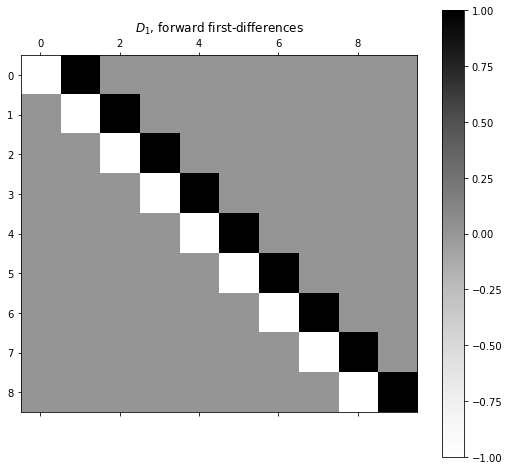

In [7]:
plt.matshow(forward_1diff(10), cmap='Greys', vmin=-1, vmax=1)
plt.colorbar(cmap='Greys')
plt.title(r'$D_1$, forward first-differences')

Text(0.5, 1.0, '$D_2$, forward second finite-differences')

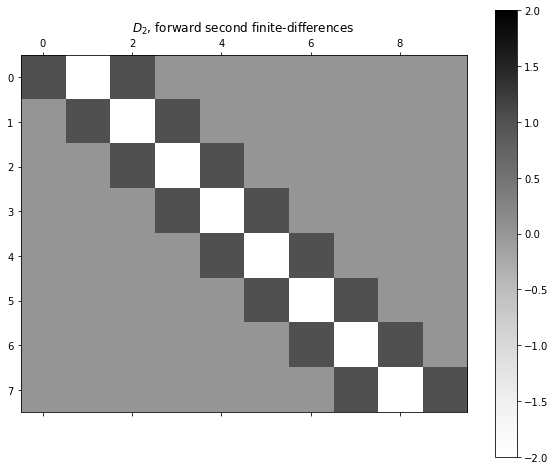

In [8]:
plt.matshow(forward_2diff(10), cmap='Greys', vmin=-2, vmax=2)
plt.colorbar(cmap='Greys')
plt.title(r'$D_2$, forward second finite-differences')

### Lorsque $R$ est différentiable

Minimisation avec $R\big( u \big) = ||D_1 u||_2^2$

In [9]:
def smooth_1diff(x, alpha=1.0):
    n = x.size
    D = forward_1diff(n)
    return np.dot( np.linalg.inv( np.eye(n) + alpha * np.dot(D.T, D)), x)

Minimisation avec $R\big( u \big) = ||D_2 u||_2^2$

In [10]:
def smooth_2diff(x, alpha=1.0):
    n = x.size
    D = forward_2diff(n)
    return np.dot( np.linalg.inv( np.eye(n) + alpha * np.dot(D.T, D)), x)

Moyenne mobile

In [11]:
def moving_average(x, order):
    """moving avergage, symmetric, centered"""
    x = np.r_[np.zeros(order//2 - 1), x, np.zeros(order//2 - 1)]
    ret = np.cumsum(x)
    ret[order:] = ret[order:] - ret[:-order]
    
    return ret[order-1:] / order

In [12]:
alpha = 1e2

In [13]:
# quadratic smoothing with forward first difference (discrete first derivative)
x_recov_d1 = smooth_1diff(x_cor, alpha)

In [14]:
# quadratic smoothing with second difference (discrete second derivative)
x_recov_d2 = smooth_2diff(x_cor, alpha)

In [15]:
x_mm = moving_average(x_cor, order=50)

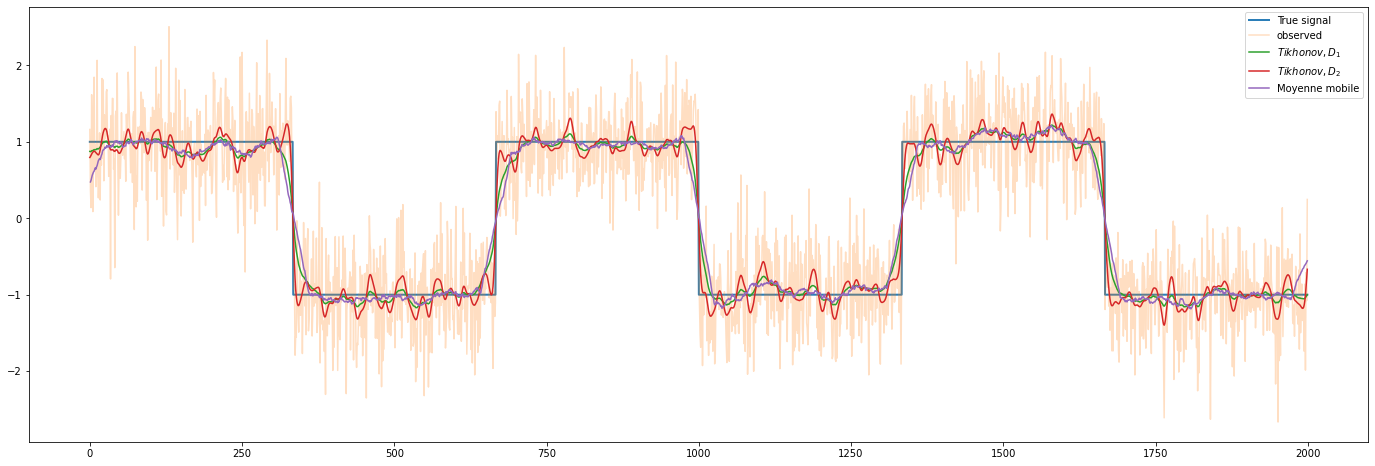

In [16]:
plt.plot(t, x_true, linewidth=2.0, alpha=0.95, label='True signal')
plt.plot(t, x_cor, alpha = 0.25, label='observed')

plt.plot(t, x_recov_d1, label=r'$Tikhonov, D_1$')
plt.plot(t, x_recov_d2, label=r'$Tikhonov, D_2$')
plt.plot(t[1:], x_mm, label='Moyenne mobile')

plt.legend()

Ces méthodes souffrent du phénomène "dual" de la reconstruction par filtrage de transformée de Fourier (phénomène de Gibbs) aux discontinuités: l'approximation tend à lisser les discontinuités, ce qui rend la conclusion, selon laquelle le signal sous-jacent est lisse, fausse !

### Lorsque $R$ n'est pas différentiable

Il convient donc d'injecter un a priori de parcimonie dans notre régularisation. La parcimonie exprime la notion de non-redondance de l'information. Dans notre cas cela se traduit par la dérivée devant être nulle (sauf aux discontinuités) presque partout. La parcimonie s'exprime avec la norme $\ell_1$. L'inconvénient de cette norme, lorsqu'utilisée comme régularisation, est qu'elle rend la fonction objectif non-différentiable en $0$, ce qui complique la minimisation. Dans ce cas on recourt à des algorithmes proximal, proximal primal/dual ou de sous-gradients (voir dans votre cours optim).

Notre problème d'optimisation est donc:
$$
(\hat{u}_t)_t = \arg \min_{(u_t)_{t \leq T}} \frac{1}{2} \sum_{i=1}^T (u_i - x_i)^2 + \alpha ||D u||_1
$$

Lorsque $D=D_1$, la solution $(\hat{x}_t)_t$ est constante par morceau, si $D=D_2$ alors la solution $(\hat{x}_t)_t$ est linéaire par morceau, etc.

Ces algorithmes, lorsqu'il y a de la non-différentiabilité dans la fonction objectif, les algorithmes ne sont pas beaucoup plus compliquées que la descente de gradient. Ici on va simplement utiliser le solveur CVXPY (open-source), par simplicité de programmation.

In [17]:
# D_1
def tv_cvx(x, lam):
    """Solve l1 trend filtering problem with CVXPY"""
    
    x_var = cp.Variable(shape=n)
    D = forward_1diff(x.size)
    # D = forward_2diff(x.size)
    obj = cp.Minimize(0.5 * cp.sum_squares(x - x_var)
                    + lam * cp.norm(D@x_var, 1) )
    prob = cp.Problem(obj)

    # ECOS and SCS solvers fail to converge before
    # the iteration limit.
    prob.solve(verbose=False, eps_rel=1e-10) # only one installed default
    return np.array(x_var.value)

In [18]:
x_tv_cvx = tv_cvx(x_cor, lam=1e1)

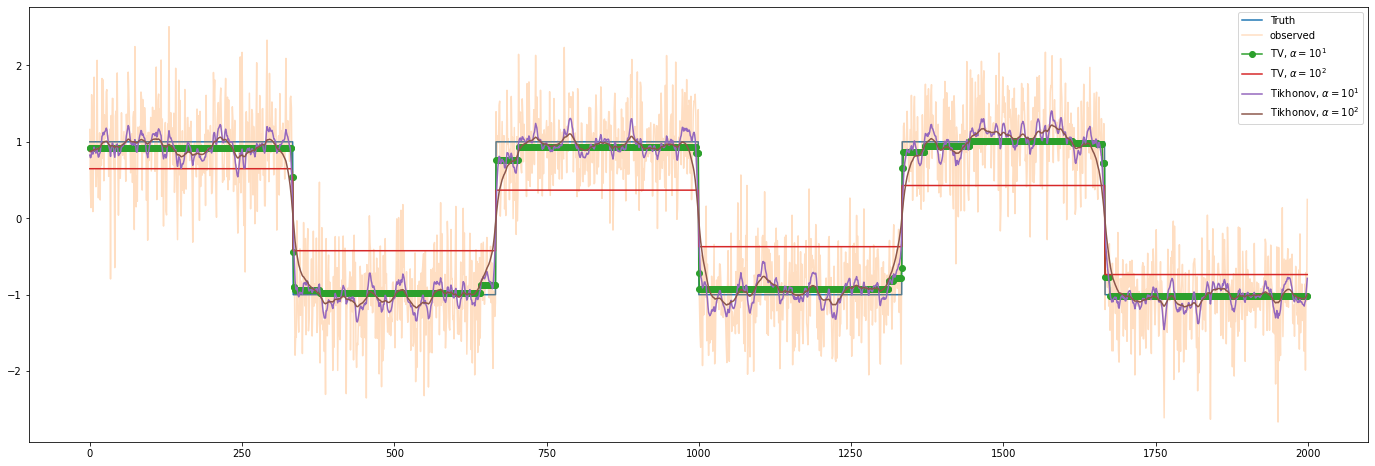

In [19]:
plt.plot(t, x_true, label='Truth')
plt.plot(t, x_cor, alpha=0.25, label='observed')
plt.plot(t, x_tv_cvx, label=r'TV, $\alpha=10^1$', marker='o')
plt.plot(t, tv_cvx(x_cor, lam=1e2), label=r'TV, $\alpha=10^2$')
plt.plot(t, smooth_1diff(x_cor, alpha=1e1), label=r'Tikhonov, $\alpha=10^1$')
plt.plot(t, smooth_1diff(x_cor, alpha=1e2), label=r'Tikhonov, $\alpha=10^2$')

plt.legend()
plt.legend()